## Merchandise Classification through Transfer Learning in Amazon SageMaker

1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
   1. [Permissions and setup](#Permissions-and-setup)
   2. [Convert train/val datasets to RecordIO format](#Convert-Train/Val-Datasets-to-RecordIO-format)
3. [Training](#Training)
   1. [Define Hyperparameters](#Define-Hyperparameters)
   2. [Specify Training Job Configuration](#Specify-Training-Job-Configuration)
   3. [Run Training Job](#Run-the-Training-Job)
   4. [Plot Training and Validation Accuracy](#Plot-Training-Results)
4. [Deploy The Model](#Deploy-the-Model)
  1. [Create model](#Create-the-Model)
  2. [Batch transform](#Create-Batch-Transform-Job)
5. [Review the results](#Review-the-results)

## Introduction

In this notebook, we will cover how seamless it is to classify images using Amazon SageMaker. It takes a lot of effort in other environments (cloud and on-premise) to a) preprocess images, b) build convolutional neural network architecture, c) specify optimal hyperparameters, d) train & deploy image classification model, and e) classify images using the trained model. 

We will leverage the trained Residual Network (ResNet) 18 model, which is trained on ImageNet dataset. ImageNet is a leading dataset used in the image and vision research fields.  ResNet-18 is a 18 layer network. 
We will use Amazon SageMaker Image Classification algorithm for distributed training in transfer learning mode to fine-tune ResNet50 for a new dataset.
The new dataset contains images of snack/lunch items. Each of the items contain 40 to 90 images, covering the item from varied angle, brightness, contrast, and size.

We are using transfer learning because it takes thousands of images to train image classification algorithms to recognize an image. Since we do not have large volume of images, we can benefit from using ResNet, which is trained on millions of images. The trained model can already recognize basic geometric features. The early layers of the network are perfectly capable of detecting of those features. Reusing that training and incrementally training ResNet on our custom images will enable the network to recognize/classify our custom images.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

In [1]:
import boto3
import shutil
from time import gmtime, strftime
import time
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cv2
import os
import mxnet as mx
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Preprocessing

### Permissions and setup
Here we set up authentication to AWS services and variables that are going to be required through the notebook. There are three parts to this:

* The roles used to give SageMaker training and hosting services access to input data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and to save model data
* The Amazon sagemaker image classification docker image which need not be changed

In [2]:
role = get_execution_role()
bucket = 'ai-in-aws'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


### Convert Train/Val Datasets to RecordIO format 

Amazon SageMaker Image Classification algorithm accepts images in file mode via two content types -- namely RecordIO (application/x-recordio) and image (image/png, image/jpeg, and application/x-image). In this notebook, we will use RecordIO format. 

RecordIO is a binary format for representing images efficiently. The format enables --
* Storing images in a compact format (reduces the size of dataset)
* Packing data together allows continuous reading on the disk
* Partitioning data, simplifying distributed setting

The training and validation images are available in zipped format on s3 bucket. In the section below, you will unzip the training and validation images and create corresponding list files. Each of the training and validation folders contain subfolder for every image category. As you will see below, the root folder (./merch_data) has subfolder (./merch_data/Glazed_Twist) for every category 

List files are used to summarize images across multiple classifications/categories. For example, list files have the following format, 

**index** \t **one or more label** \t **path** <br>

225  3.000000 Hot_Dog_1/IMG_20180711_180420838.jpg

From the list files, we then create compressed representation of images via RecordIO format. MXNet offers im2rec.py module to conduct this conversion

In [3]:
s3_prefix = 'image-classification-merchandise'
s3_train_fname = 'Train.zip' # name of training dataset 
s3_val_fname = 'Validation.zip' # name of validation dataset 

s3_client = boto3.client('s3')
item_categories = ['Berry_Donut', 'Glazed_Twist', 'Hot_Dog_1', 'Muffin', 'Peanut_Butter_Cookie']

# 4.000000	Peanut_Butter_Cookie
# 2.000000	Hot_Dog_1
# 3.000000	Muffin
# 0.000000	Berry_Donut
# 1.000000	Glazed_Twist

# Upload test data to s3 bucket
batch_input = 's3://{}/image-classification-merchandise/test/'.format(bucket)
# Make sure that test data is loaded in this path (local sagemaker instance)
test_images = 'merch_data/test/'

!aws s3 cp $test_images $batch_input --recursive --quiet 

**User defined functions**

In [4]:
run UtilityFunctions.py

**Initialize environment variables**

In [5]:
# Initialize variables
train_key = os.path.join(s3_prefix, s3_train_fname)
val_key = os.path.join(s3_prefix, s3_val_fname)

path = 'merch_data'
train_prefix = 'train'
val_prefix = 'val'

# Define list file names
listfile_train_prefix = os.path.join(path,'merch-train')
listfile_val_prefix = os.path.join(path,'merch-val')

# Define location where the list files need to be saved
rel_train_path = os.path.join(path, train_prefix)
rel_val_path = os.path.join(path, val_prefix)

**Create and Upload RecordIO files to S3**

In [6]:
# Step 1: Extract the zip file, both training and validation
# Step 2: Create list files for training and validation
# Step 3: Create Record IO files for training and validation

# Extract training and validation zipped folders to merch_data/<train/val>
extract_zipfile(bucket, train_key, rel_train_path)
extract_zipfile(bucket, val_key, rel_val_path)

# Create List files (./merch_data)
create_listfile(rel_train_path, listfile_train_prefix) #data path, prefix path
create_listfile(rel_val_path, listfile_val_prefix)

# # Create Record IO file
# data path  --> prefix path (location of list file)
# mxnet's im2rec.py uses ./merch_data folder to locate .lst files for train and val
# mxnet's im2rec.py uses ./merch_data/<train/val> as data path
# list files are used to create recordio files

create_recordio(rel_train_path, listfile_train_prefix)
create_recordio(rel_val_path, listfile_val_prefix)

In [7]:
# Move Record IO file to the same location as the notebook
# destination, source
!rm 'merch-train.rec'
!rm 'merch-val.rec'

shutil.move(os.path.join(path, 'merch-train.rec'), '.')
shutil.move(os.path.join(path, 'merch-val.rec'), '.')

'./merch-val.rec'

In [8]:
s3_train_key = 'image-classification-merchandise/train'
s3_validation_key = 'image-classification-merchandise/validation'
s3_train = 's3://{}/{}'.format(bucket, s3_train_key)
s3_validation = 's3://{}/{}'.format(bucket, s3_validation_key)


upload_to_s3(bucket, s3_train_key, 'merch-train.rec')
upload_to_s3(bucket, s3_validation_key, 'merch-val.rec')

## Training

We are now ready to train the image classification algorithm. There are two kinds of parameters that we specify: <br>
* Parameters for the training job. The input and output configuration, including the type of infrastructure to provision
* Hyperparameters that are specific to algorithm
> -  **num_layers**: The number of layers for the network. In this example, we will use the default 18 layers
> -  **image_shape**: Since we are using pre-trained ResNet50, we will keep our image size consistent with the specifications of ImageNet dataset
> -  **num_training_samples**: This is the total number training data points. In our case, it is set to 302
> -  **num_classes**: This is number of categories. For our dataset, it is 5. We will classify 5 merchandise
> -  **mini_batch_size**: The number of training samples used for each mini batch. In a single machine multi-GPU setting, each GPU handles mini_batch_size/num of GPUs samples. In the case of distributed training, where multiple machines are involved, the actual batch size is number of machines * mini_batch_size 
> -  **epochs**: Number of iterations to go through to train the classification algorithm
> -  **learning_rate**: Define how big the steps should be when back propagating to reduce loss. In the case of transfer learning, we will take smaller steps, so we can incrementally train the pre-trained network

### Define Hyperparameters

In [9]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers

num_layers = 18
image_shape = "3,224,224" # Number of channels for color image, Number of rows, and columns (blue, green and red)
num_training_samples = 302 # number of training samples in the training set
num_classes = 5 # specify the number of output classes
mini_batch_size =  60 # batch size for training
# number of epochs
epochs = 4
# learning rate
learning_rate = 0.01
top_k=2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1
#augmentation_type = 'crop_color_transform'

### Specify Training Job Configuration

In [10]:
%%time

s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'merch-imageclassification'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp

training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": { # location of output
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": { # provision one GPU machine
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
       # "augmentation_type": str(augmentation_type)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: merch-imageclassification-2019-03-13-11-40-32

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://ai-in-aws/image-classification-merchandise/train', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 5.63 ms, sys: 0 ns, total: 5.63 ms
Wall time: 5.57 ms


### Run the Training Job

In [11]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


### Plot Training Results

In [12]:
log_client = boto3.client('logs')
lgn = '/aws/sagemaker/TrainingJobs' # log group name
lsn = 'merch-imageclassification-2019-03-13-11-40-32/algo-1-1552477444'   # log stream name
log = log_client.get_log_events(logGroupName=lgn, logStreamName=lsn)

trn_acc = []
val_acc = []

# iterate through the events in log group name and log stream name
# Get train and validation accuracy lists
for e in log['events']:
    msg = e['message']
    #print(msg)
    if 'Validation-accuracy' in msg:
        val = msg.split('=')
        if 'INFO' not in val[0]:
            val = val[1]
            val_acc.append(float(val))
    if 'Train-accuracy' in msg:
        trn = msg.split('=')
        if 'INFO' not in trn[0]:
            trn = trn[1]
            trn_acc.append(float(trn))    
        
print('Maximum validation accuracy: %f '%max(val_acc))

Maximum validation accuracy: 0.716667 


In [13]:
trn_acc

[0.366667, 0.86, 0.966667, 0.986667]

In [14]:
val_acc

[0.45, 0.583333, 0.583333, 0.716667]

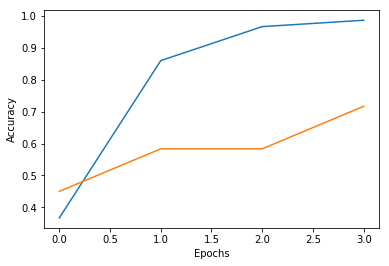

In [15]:
fig, ax = plt.subplots()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

trn_plot = ax.plot(range(epochs), trn_acc, label='Training accuracy')
val_plot = ax.plot(range(epochs), val_acc, label='Validation accuracy')

plt.show()

## Deploy the Model

### Create the Model

In [17]:
# Create multiple models
model_type = '-plain'

In [18]:
sage = boto3.Session().client(service_name='sagemaker') 

model_name="MERCH-image-classification-model" + model_type
print(model_name)


info = sage.describe_training_job(TrainingJobName=job_name)
# Get S3 location of the model artifacts
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

# Get the docker image of image classification algorithm
hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

# Create model 
create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

MERCH-image-classification-model-plain
s3://ai-in-aws/merch-imageclassification/output/merch-imageclassification-2019-03-13-11-40-32/output/model.tar.gz
arn:aws:sagemaker:us-east-1:109099157774:model/merch-image-classification-model-plain


### Create Batch Transform Job

We will create batch transform job to classify 5 images

In [20]:
%%time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "merch-classification-model" + timestamp

request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
print('\nInput Data Location: {}'.format(batch_input))

Transform job name: merch-classification-model-2019-03-13-11-59-13

Input Data Location: s3://ai-in-aws/image-classification-merchandise/test/
CPU times: user 212 µs, sys: 39 µs, total: 251 µs
Wall time: 171 µs


In [21]:
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)  

Created Transform job with name:  merch-classification-model-2019-03-13-11-59-13
Transform job ended with status: Completed


## Review the results

In [ ]:
# Image resizing logic - do not have to do this since SageMaker Image Classification algo handles this
# for ip_image in os.listdir(test_images):
#     if '.jpg' in ip_image:
#         with open(test_images + ip_image, 'rb') as fp:
#             str_image = fp.read()
#             image = mx.img.imdecode(str_image)
#             new_image = mx.img.imresize(image, 224, 224)
#             plt.imshow(new_image.asnumpy())
#             plt.show()
#             im = Image.fromarray(new_image.asnumpy())
#             im.save(test_images + ip_image)

Sample inputs: ['image-classification-merchandise/test/IMG_20180711_180812145.jpg']
Sample output: ['merch-classification-model-2019-03-13-11-59-13/output/IMG_20180711_180812145.jpg.out']
Result: label - Hot_Dog_1, probability - 0.9236235022544861


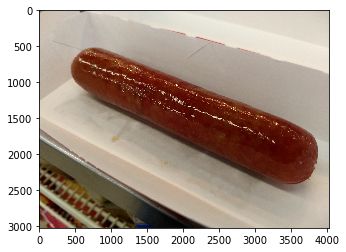

Result: label - Berry_Donut, probability - 0.9964750409126282


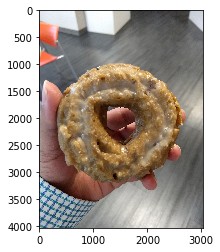

Result: label - Muffin, probability - 0.6657814979553223


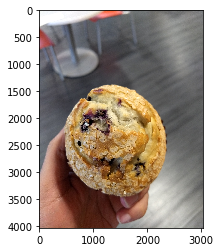

Result: label - Muffin, probability - 0.8914210200309753


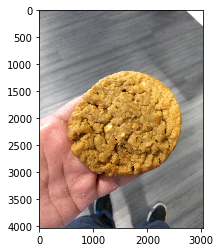

[('Hot_Dog_1', 0.9236235022544861),
 ('Berry_Donut', 0.9964750409126282),
 ('Muffin', 0.6657814979553223),
 ('Muffin', 0.8914210200309753)]

In [24]:
inputs = get_items(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
print("Sample inputs: " + str(inputs[:1]))

outputs = get_items(s3_client, bucket, batch_job_name + "/output")
print("Sample output: " + str(outputs[:1]))

# Check prediction result of all the images
[get_label_img(s3_client, bucket, prefix, test_images, item_categories) for prefix in outputs]
